# Noise variance experiment

In [1]:
import os 
import torch

def load_all_batches(path : str, max_num_batches : int=None) -> dict[str, torch.Tensor]:
    # during inference, the samples are saved as batches 
    # this function concatenates all batches into a single list
    
    # find all files on the form batch_*.pt
    files = [f for f in os.listdir(path) if f.startswith("batch_") and f.endswith(".pt")]
    if max_num_batches is not None:
        files = files[:max_num_batches]
    files.sort()  # sort files to ensure consistent order
    x0s, x1s, x0_recons, trajectories = [], [], [], []
    for file in files:
        batch = torch.load(os.path.join(path, file), weights_only=True)
        x0s.append(batch["x0"])
        x1s.append(batch["x1"])
        x0_recons.append(batch["x0_recon"])
        trajectories.append(batch["trajectory"])
    # concatenate all batches into a single tensor
    x0 = torch.cat(x0s, dim=0)
    x1 = torch.cat(x1s, dim=0)
    x0_recon = torch.cat(x0_recons, dim=0)
    trajectory = torch.cat(trajectories, dim=1)
    return {
        "x0": x0,
        "x1": x1,
        "x0_recon": x0_recon,
        "trajectory": trajectory
    }
    

# Noise factor experiment

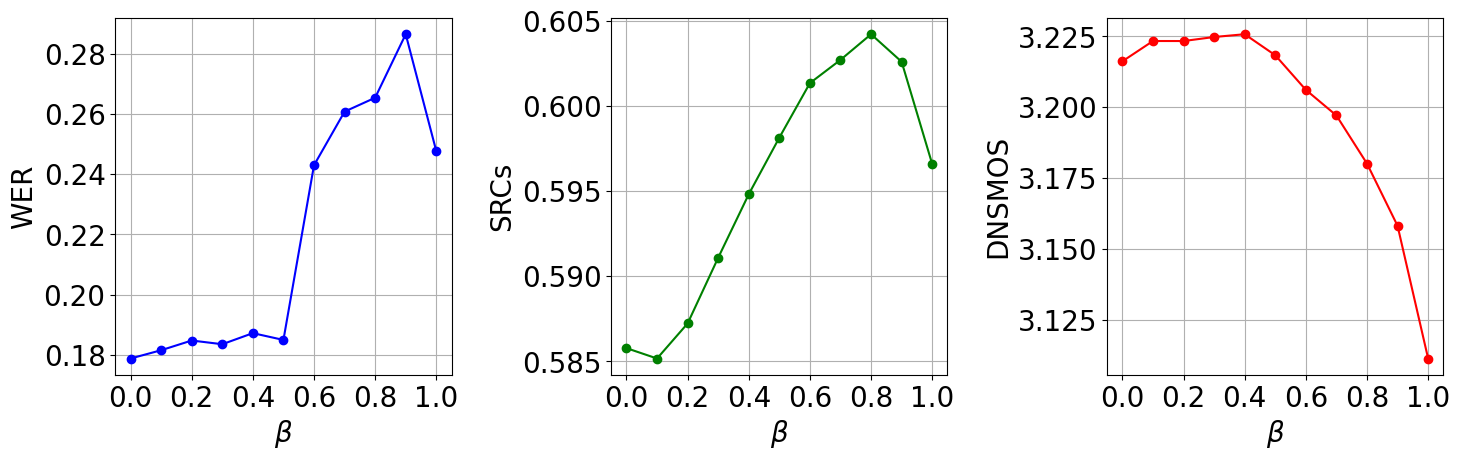

In [3]:
import torch
import matplotlib.pyplot as plt

noise_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

data = {
    'wer': dict(),
    'srcs': dict(),
    'dnsmos': dict(),
}

for noise_factor in noise_factors:
    noise_factor_str = str(noise_factor).replace('.', '_')
    p = f"test_results/noise_factor/experiment_id_020625101550_num_samples_256_batch_size_64_length_seconds_4_47_sdr_None_num_steps_None_noise_factor_{noise_factor_str}_dsb_iteration_None_noise_variance_False_use_clipped_libri_True_folder_name_noise_factor_"
    metrics = torch.load(p + "/metrics.pt", weights_only=True)
    wer_mean = torch.tensor(metrics['wer']).mean()
    srcs_mean = torch.tensor(metrics['srcs']).mean()
    dnsmos_mean = torch.tensor(metrics['dnsmos']).mean()
    data['wer'][noise_factor] = wer_mean
    data['srcs'][noise_factor] = srcs_mean
    data['dnsmos'][noise_factor] = dnsmos_mean
    
# visualize as as points
# make three subplots, one for each metric
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.rcParams.update({'font.size': 20})

axs : list[plt.Axes]
axs[0].plot(noise_factors, [data['wer'][nf] for nf in noise_factors], marker='o', linestyle='-', color='b')
axs[1].plot(noise_factors, [data['srcs'][nf] for nf in noise_factors], marker='o', linestyle='-', color='g')
axs[2].plot(noise_factors, [data['dnsmos'][nf] for nf in noise_factors], marker='o', linestyle='-', color='r')

metrics = ['WER', 'SRCs', 'DNSMOS']
for i in range(3):
    axs[i].set_xlabel(r"$\beta$")
    axs[i].set_ylabel(metrics[i])
    axs[i].set_xticks(noise_factors[::2])
    axs[i].grid(True)
plt.tight_layout()
plt.savefig("test_results/noise_factor/metrics_vs_noise_factor.png", dpi=300)
plt.show()


# Num steps

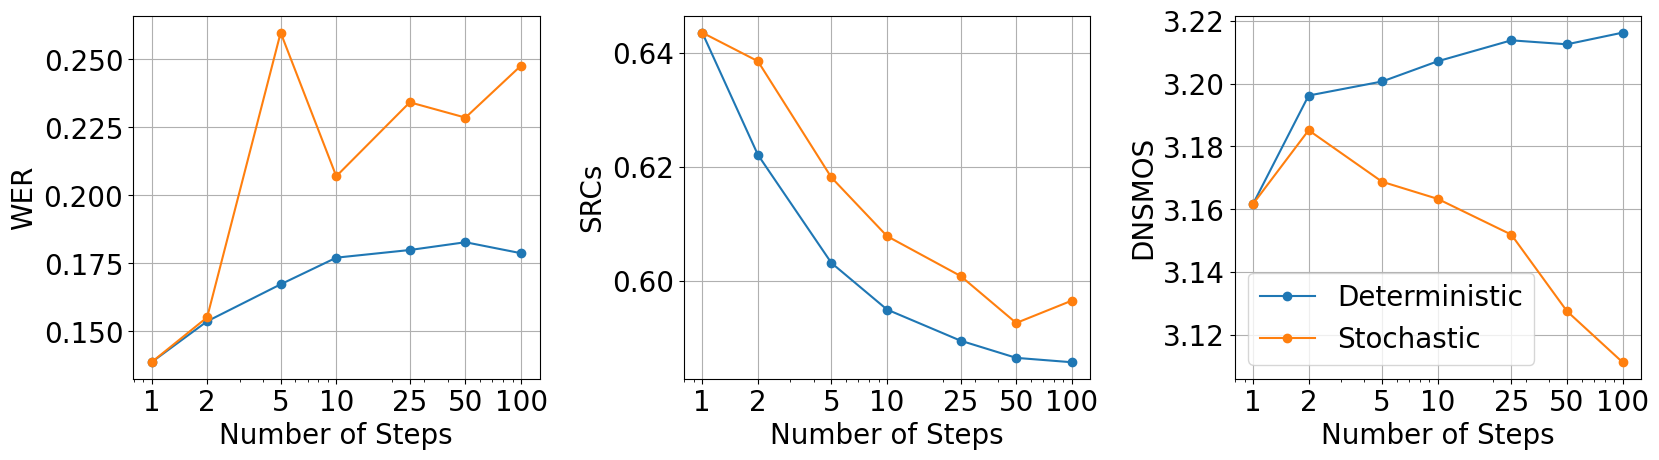

In [4]:
import torch

num_steps = [100, 50, 25, 10, 5, 2, 1]

deterministc_data = dict()
stochastic_data = dict()

for noise_factor in [0, 1]:
    for num_step in num_steps:
        path = f"test_results/num_steps/experiment_id_020625101550_num_samples_256_batch_size_64_length_seconds_4_47_sdr_None_num_steps_{num_step}_noise_factor_{noise_factor}_0_dsb_iteration_None_noise_variance_False_use_clipped_libri_True_folder_name_num_steps_"
        metrics = torch.load(path + "/metrics.pt", weights_only=True)
        wer_mean = torch.tensor(metrics['wer']).mean().item()
        srcs_mean = torch.tensor(metrics['srcs']).mean().item()
        dnsmos_mean = torch.tensor(metrics['dnsmos']).mean().item()
        if noise_factor == 0:
            deterministc_data[num_step] = {
                'wer': wer_mean,
                'srcs': srcs_mean,
                'dnsmos': dnsmos_mean
            }
        else:
            stochastic_data[num_step] = {
                'wer': wer_mean,
                'srcs': srcs_mean,
                'dnsmos': dnsmos_mean
            }
            
import matplotlib.pyplot as plt

# visualize as as points
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
plt.rcParams.update({'font.size': 20})
axs : list[plt.Axes]
axs[0].plot(num_steps, [deterministc_data[ns]['wer'] for ns in num_steps], marker='o', linestyle='-', label='Deterministic')
axs[0].plot(num_steps, [stochastic_data[ns]['wer'] for ns in num_steps], marker='o', linestyle='-', label='Stochastic')
axs[1].plot(num_steps, [deterministc_data[ns]['srcs'] for ns in num_steps], marker='o', linestyle='-', label='Deterministic')
axs[1].plot(num_steps, [stochastic_data[ns]['srcs'] for ns in num_steps], marker='o', linestyle='-', label='Stochastic')
axs[2].plot(num_steps, [deterministc_data[ns]['dnsmos'] for ns in num_steps], marker='o', linestyle='-', label='Deterministic')
axs[2].plot(num_steps, [stochastic_data[ns]['dnsmos'] for ns in num_steps], marker='o', linestyle='-', label='Stochastic')
metrics = ['WER', 'SRCs', 'DNSMOS']
for i in range(3):
    axs[i].set_xlabel("Number of Steps")
    axs[i].set_ylabel(metrics[i])
    axs[i].set_xticks(num_steps)
    axs[i].grid(True)
    axs[i].set_xscale('log')
    axs[i].set_xticks(num_steps)
    axs[i].set_xticklabels(num_steps)
    if i == 2:
        axs[i].legend()
plt.tight_layout()
plt.savefig("test_results/num_steps/metrics_vs_num_steps.png", dpi=300)
plt.show()


# dsb iterations

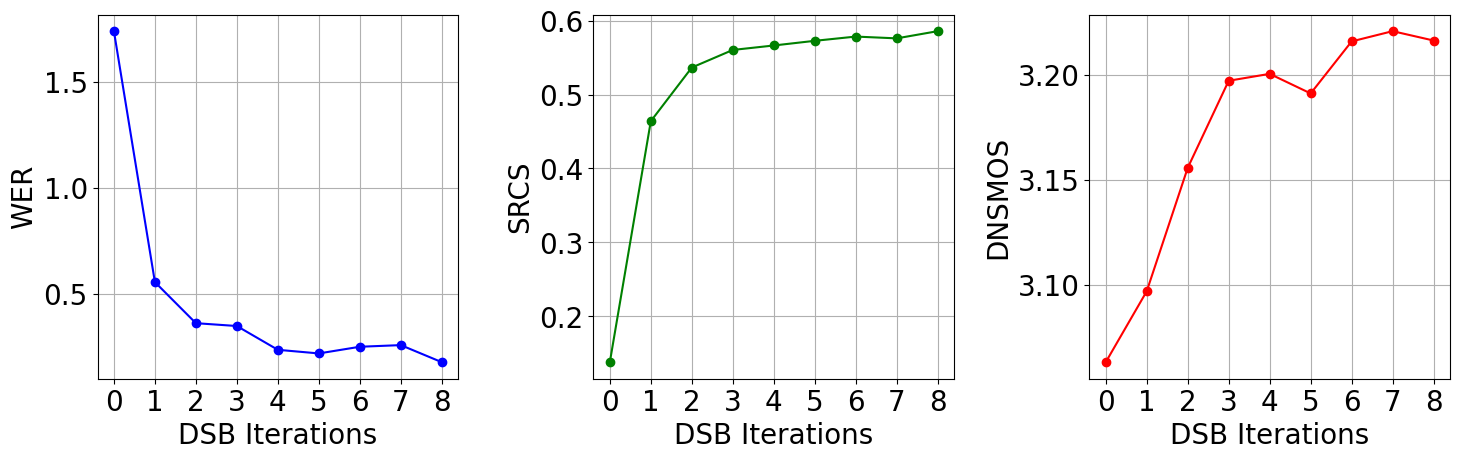

In [5]:
import matplotlib.pyplot as plt
import torch

dsb_iterations = list(range(0, 9))
data = {
    'wer': dict(),
    'srcs': dict(),
    'dnsmos': dict(),
}
for dsb_iteration in dsb_iterations:
    path = f"test_results/dsb_iterations/experiment_id_020625101550_num_samples_256_batch_size_64_length_seconds_4_47_sdr_None_num_steps_None_noise_factor_0_0_dsb_iteration_{dsb_iteration}_noise_variance_False_use_clipped_libri_True_folder_name_dsb_iterations_"
    metrics = torch.load(path + "/metrics.pt", weights_only=True)
    wer_mean = torch.tensor(metrics['wer']).mean()
    srcs_mean = torch.tensor(metrics['srcs']).mean()
    dnsmos_mean = torch.tensor(metrics['dnsmos']).mean()
    data['wer'][dsb_iteration] = wer_mean
    data['srcs'][dsb_iteration] = srcs_mean
    data['dnsmos'][dsb_iteration] = dnsmos_mean
    
# visualize the results as points
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.rcParams.update({'font.size': 20})
axs : list[plt.Axes]
axs[0].plot(dsb_iterations, [data['wer'][di] for di in dsb_iterations], marker='o', linestyle='-', color='b')
axs[1].plot(dsb_iterations, [data['srcs'][di] for di in dsb_iterations], marker='o', linestyle='-', color='g')
axs[2].plot(dsb_iterations, [data['dnsmos'][di] for di in dsb_iterations], marker='o', linestyle='-', color='r')

metrics = ['WER', 'SRCS', 'DNSMOS']
for i in range(3):
    axs[i].set_xlabel("DSB Iterations")
    axs[i].set_ylabel(metrics[i])
    axs[i].set_xticks(dsb_iterations)
    axs[i].grid(True)
plt.tight_layout()
plt.savefig("test_results/dsb_iterations/metrics_vs_dsb_iterations.png", dpi=300)
plt.show()

In [6]:
from src.callbacks.metrics import calculate_curvature_displacement
import torch
from tqdm import tqdm

dsb_iterations = list(range(0, 9))

data = dict()
for i, dsb_iteration in enumerate(tqdm(dsb_iterations)):
    path = f"test_results/dsb_iterations/experiment_id_020625101550_num_samples_256_batch_size_64_length_seconds_4_47_sdr_None_num_steps_None_noise_factor_0_0_dsb_iteration_{dsb_iteration}_noise_variance_False_use_clipped_libri_True_folder_name_dsb_iterations_"

    if i == 0:
        params = torch.load(path + "/params.pt", weights_only=True)
        timeschedule = params['timeschedule']
    batch = load_all_batches(path)
    trajectory = batch["trajectory"]
    Ct = calculate_curvature_displacement(trajectory, timeschedule)
    Ct_mean = Ct.mean(dim=0)
    Ct_std = Ct.std(dim=0)
    data[dsb_iteration] = {
        'Ct_mean': Ct_mean,
        'Ct_std': Ct_std
    }


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
100%|██████████| 9/9 [01:01<00:00,  6.82s/it]


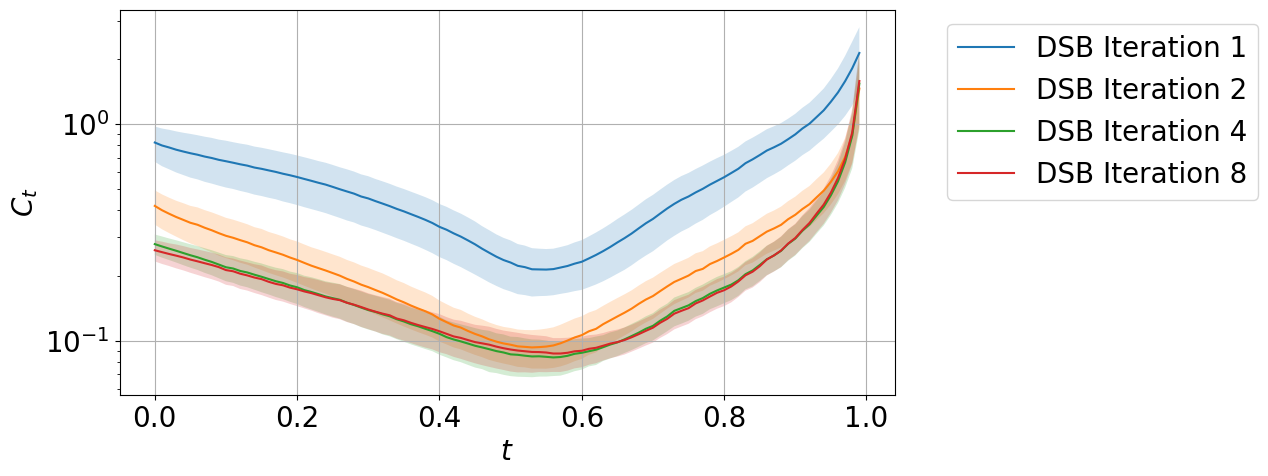

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.rcParams.update({'font.size': 20})
dsb_iterations_to_plot = [1, 2, 4, 8]
for dsb_iteration in dsb_iterations_to_plot:
    axs.plot(data[dsb_iteration]['Ct_mean'], label=f"DSB Iteration {dsb_iteration}")
    axs.fill_between(
        range(len(data[dsb_iteration]['Ct_mean'])),
        data[dsb_iteration]['Ct_mean'] - data[dsb_iteration]['Ct_std'],
        data[dsb_iteration]['Ct_mean'] + data[dsb_iteration]['Ct_std'],
        alpha=0.2
    )
    
axs.grid(True)
yticks = [10**i for i in range(-2, 1)]
xticks = [i for i in range(0, 101, 20)]
xlabels = [i / 100 for i in xticks]
axs.set_xticks(xticks)
axs.set_xticklabels(xlabels)
axs.set_yticks(yticks)
axs.set_yticklabels([str(tick) for tick in yticks])
axs.set_yscale('log')
axs.set_xlabel("$t$")
axs.set_ylabel("$C_t$")
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("test_results/dsb_iterations/Ct_vs_dsb_iterations.png", dpi=300, bbox_inches='tight')
plt.show()

# compare DSB and GFB

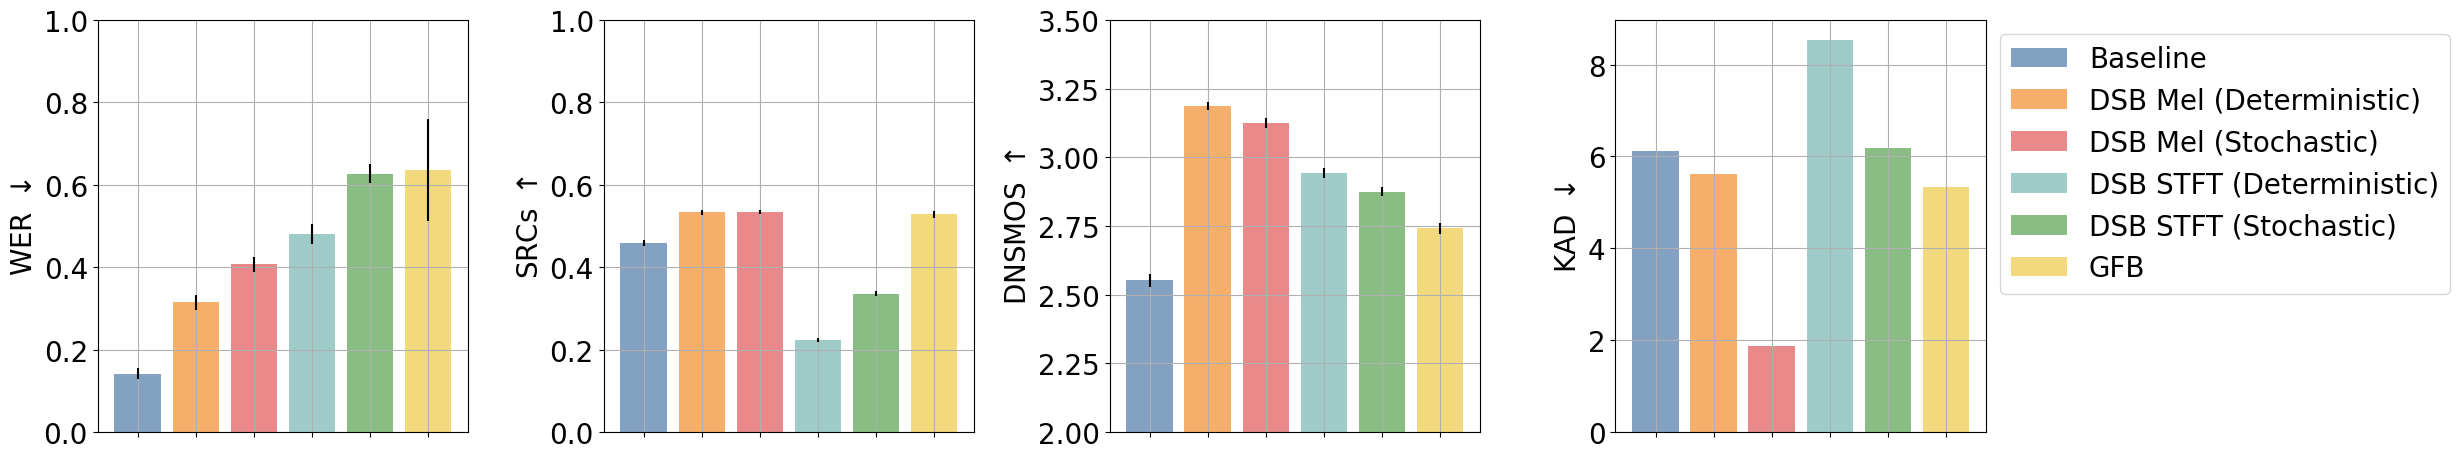

In [22]:
import torch

paths = ['baseline', 'mel_det', 'mel_sto', 'stft_det', 'stft_sto', 'gfb']
names = ["Baseline", "DSB Mel (Deterministic)", "DSB Mel (Stochastic)", "DSB STFT (Deterministic)", "DSB STFT (Stochastic)", "GFB"]
data = dict()

for path in paths:
    path = f"test_results/comparison/{path}"
    metrics = torch.load(path + "/metrics.pt", weights_only=True)
    
    wer_values = torch.tensor(metrics['wer'])
    srcs_values = torch.tensor(metrics['srcs'])
    dnsmos_values = torch.tensor(metrics['dnsmos'])
    
    wer_mean = wer_values.mean().item()
    srcs_mean = srcs_values.mean().item()
    dnsmos_mean = dnsmos_values.mean().item()
    wer_err = wer_values.std().item() / (len(wer_values) ** 0.5)
    srcs_err = srcs_values.std().item() / (len(srcs_values) ** 0.5)
    dnsmos_err = dnsmos_values.std().item() / (len(dnsmos_values) ** 0.5)
    kad = metrics['kad']
    
    batch = load_all_batches(path, max_num_batches=1)
    x1 = batch["x1"]
    x0_recon = batch["x0_recon"]        

    data[path] = {
        'wer': (wer_mean, wer_err),
        'srcs': (srcs_mean, srcs_err),
        'dnsmos': (dnsmos_mean, dnsmos_err),
        'kad': kad,
        'x1': x1,
        'x0_recon': x0_recon
    }

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
plt.rcParams.update({'font.size': 20})
axs : list[plt.Axes]
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']

for i, (key, value) in enumerate(data.items()):
    color = colors[i]
    
    wer_mean, wer_err = value['wer']
    srcs_mean, srcs_err = value['srcs']
    dnsmos_mean, dnsmos_err = value['dnsmos']
    kad = value['kad']
    
    axs[0].bar(i, wer_mean, yerr=wer_err, color=color, alpha=0.7)
    axs[1].bar(i, srcs_mean, yerr=srcs_err, color=color, alpha=0.7)
    axs[2].bar(i, dnsmos_mean, yerr=dnsmos_err, color=color, alpha=0.7)
    axs[3].bar(i, kad, color=color, alpha=0.7, label=names[i])
    
for i in range(4):
    axs[i].set_ylabel([r"WER $\downarrow$", r"SRCs $\uparrow$", r"DNSMOS $\uparrow$", r"KAD $\downarrow$"][i])
    axs[i].set_xticks(range(len(data)))
    axs[i].set_xticklabels([""] * len(data))
    axs[i].grid(True)
    
axs[0].set_ylim(0, 1.0)
axs[1].set_ylim(0, 1)
axs[2].set_ylim(2,3.5)
    
axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"test_results/comparison/metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
from IPython.display import display, Audio

for i, (key, value) in enumerate(data.items()):
    x1 : torch.Tensor = value['x1']
    x0_recon : torch.Tensor = value['x0_recon']
    x1_audio = x1[1].flatten()
    x0_recon_audio = x0_recon[1].flatten()
    print(names[i])
    display(Audio(x1_audio.cpu().numpy(), rate=16000, normalize=False))
    display(Audio(x0_recon_audio.cpu().numpy(), rate=16000, normalize=False))
    

Baseline


DSB Mel (Deterministic)


DSB Mel (Stochastic)


DSB STFT (Deterministic)


DSB STFT (Stochastic)


GFB


In [3]:
from src.callbacks.metrics import calculate_curvature_displacement
from torch import Tensor

def calculate_gfb_curvature(trajectories : Tensor, timeschedule : Tensor) -> Tensor:
    timeschedule = torch.cat([torch.tensor([0.0]), timeschedule], dim=0)
    n_steps = trajectories.shape[0]
    
    forward = trajectories[:n_steps // 2]
    backward = trajectories[n_steps // 2:]
    
    forward_Ct = calculate_curvature_displacement(forward, timeschedule)
    backward_Ct = calculate_curvature_displacement(backward, timeschedule) # ideally, timeschedule should be reversed but it is symmetric
    backward_Ct = backward_Ct.flip(dims=[0])  # reverse the backward curvature
    
    C_ts = torch.cat([forward_Ct, backward_Ct], dim=1)
    return C_ts

def calculate_gfb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    print(f"Trajectory shape: {trajectories.shape}, timeschedule length: {len(timeschedule)}")
    return calculate_gfb_curvature(trajectories, timeschedule)

def calculate_dsb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    print(f"Trajectory shape: {trajectories.shape}, timeschedule length: {len(timeschedule)}")
    return calculate_curvature_displacement(trajectories, timeschedule)

gfb_path = "/work3/s214630/Latent-DSB/test_results/comparison/gfb"
dsb_path = "/work3/s214630/Latent-DSB/test_results/comparison/stft_det"
gfb_cts = calculate_gfb_curvature_from_path(gfb_path, max_num_batches=1)
dsb_cts = calculate_dsb_curvature_from_path(dsb_path, max_num_batches=1)


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


Trajectory shape: torch.Size([32, 16, 1, 65536]), timeschedule length: 15
Trajectory shape: torch.Size([31, 16, 1, 65536]), timeschedule length: 31


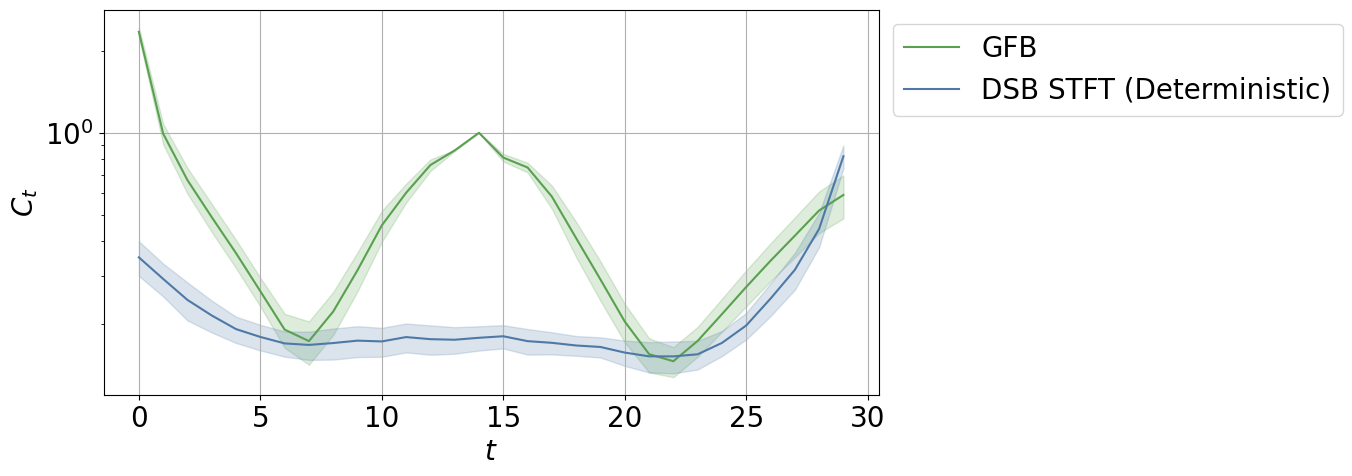

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.rcParams.update({'font.size': 20})
axs.plot(gfb_cts.mean(dim=0).cpu().numpy(), label="GFB", color='#59A14F')
axs.fill_between(
    range(len(gfb_cts.mean(dim=0))),
    gfb_cts.mean(dim=0).cpu().numpy() - gfb_cts.std(dim=0).cpu().numpy(),
    gfb_cts.mean(dim=0).cpu().numpy() + gfb_cts.std(dim=0).cpu().numpy(),
    alpha=0.2, color='#59A14F'
)
axs.plot(dsb_cts.mean(dim=0).cpu().numpy(), label="DSB STFT (Deterministic)", color='#4E79A7')
axs.fill_between(
    range(len(dsb_cts.mean(dim=0))),
    dsb_cts.mean(dim=0).cpu().numpy() - dsb_cts.std(dim=0).cpu().numpy(),
    dsb_cts.mean(dim=0).cpu().numpy() + dsb_cts.std(dim=0).cpu().numpy(),
    alpha=0.2, color='#4E79A7'
)
axs.grid(True)
axs.set_xlabel("$t$")
axs.set_yscale('log')
axs.set_ylabel("$C_t$")
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))


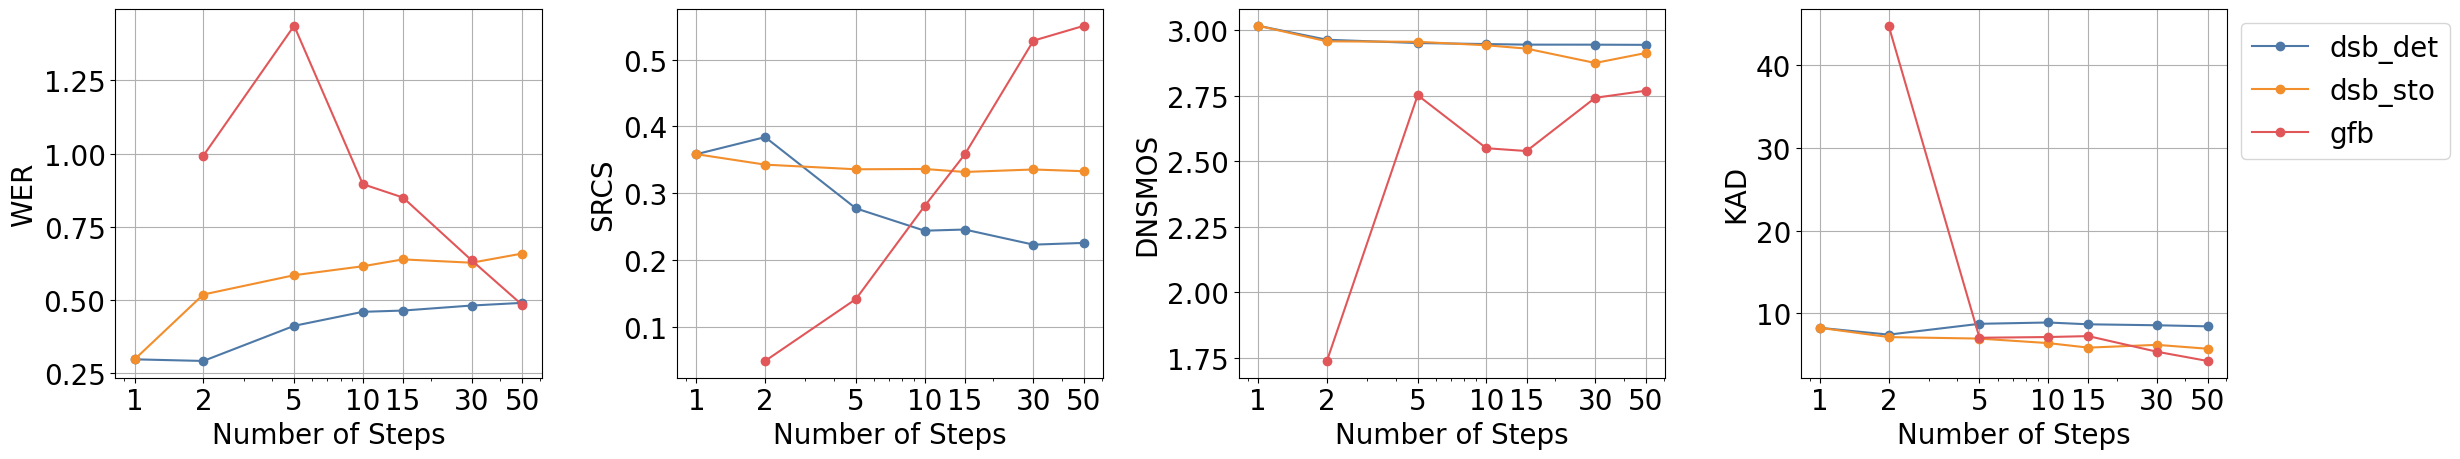

In [27]:
import matplotlib.pyplot as plt
import torch

data = dict()

num_steps = [50, 30, 15, 10, 5, 2, 1]
for model in ['dsb_det', 'dsb_sto', 'gfb']:
    data[model] = dict()
    for metric in ['wer', 'srcs', 'dnsmos', 'kad']:
        metric_list = []
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            path = f"test_results/num_steps/{model}_{num_step}"
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_list.append(value)
            
        data[model][metric] = metric_list

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 20})
colors = ['#4E79A7', '#F28E2B', '#E15759']

for i, (model, metrics) in enumerate(data.items()):
    color = colors[i]
    
    xvalues = num_steps if model != 'gfb' else num_steps[:-1]  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['wer'], marker='o', linestyle='-', color=color, label=model)
    axs[1].plot(xvalues, metrics['srcs'], marker='o', linestyle='-', color=color)
    axs[2].plot(xvalues, metrics['dnsmos'], marker='o', linestyle='-', color=color)
    axs[3].plot(xvalues, metrics['kad'], marker='o', linestyle='-', color=color, label=model)
for i in range(4):
    axs[i].set_xlabel("Number of Steps")
    axs[i].set_ylabel(["WER", "SRCS", "DNSMOS", "KAD"][i])
    axs[i].set_xticks(num_steps)
    axs[i].grid(True)
    axs[i].set_xscale('log')
    axs[i].set_xticks(num_steps)
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

    

# Make test data

In [ ]:
from src.dataset import ClippedLibri
from tqdm import tqdm
import torchaudio
import os
import torch

torch.manual_seed(42)
input("Press Enter to start generating test samples...")
dataset = ClippedLibri(length_seconds=5.0, sample_rate=16000, train=False, return_pair=True)
path = "/work3/s214630/data/clipped_libri_test/"
os.makedirs(path, exist_ok=True)
gain_db = dataset.what_db_for_sdr(target_snr=2.0)
n_samples = 256
for i in tqdm(range(n_samples)):
    x0, x1 = dataset.get_item(i, gain_db=gain_db)
    torchaudio.save(path + f"x0_{i}.wav", x0, sample_rate=16000)
    torchaudio.save(path + f"x1_{i}.wav", x1, sample_rate=16000)

100%|██████████| 256/256 [00:04<00:00, 63.33it/s]
